In [60]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "./data_sets/"

df_patients= pd.read_csv(data_path + 'PATIENTS.csv.gz')        
df_admissions = pd.read_csv(data_path + 'ADMISSIONS.csv.gz')        
df_icustays = pd.read_csv(data_path + 'ICUSTAYS.csv.gz')     
df_diagnoses = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz', low_memory=False) 


In [61]:
# Filter for Pneumonia (ICD-9 = 48283)
df_diagnoses = df_diagnoses[df_diagnoses['ICD9_CODE'] == '48283'][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

# Merge with admissions to get LOS
df_admissions_merged = pd.merge(
    df_diagnoses,
    df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ETHNICITY']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)

df_icustays_merged = pd.merge(
    df_admissions_merged,
    df_icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'LOS']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)

df_icustays_patients_merged = pd.merge(
    df_icustays_merged,
    df_patients[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)

print(df_icustays_patients_merged.shape)
df_icustays_patients_merged.head(1)

(307, 10)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,DOB
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED,258626,2146-08-29 17:59:00,1.8132,M,2098-05-09 00:00:00


In [62]:
df_icustays_patients_merged['DOB'] = pd.to_datetime(df_icustays_patients_merged['DOB'])
df_icustays_patients_merged['INTIME'] = pd.to_datetime(df_icustays_patients_merged['INTIME'])
df_icustays_patients_merged['ADMITTIME'] = pd.to_datetime(df_icustays_patients_merged['ADMITTIME'])

# Correctly subtract the years
df_icustays_patients_merged['AGE'] = (
    (df_icustays_patients_merged['INTIME'].dt.year - df_icustays_patients_merged['DOB'].dt.year) + 
    (df_icustays_patients_merged['INTIME'].dt.dayofyear - df_icustays_patients_merged['DOB'].dt.dayofyear) / 365.25
)
# Time since admitted in the hospital
df_icustays_patients_merged['HOSP_TIME'] = (
    (df_icustays_patients_merged['INTIME'].dt.year - df_icustays_patients_merged['ADMITTIME'].dt.year) + 
    (df_icustays_patients_merged['INTIME'].dt.dayofyear - df_icustays_patients_merged['ADMITTIME'].dt.dayofyear) / 365.25
)

# Can drop DOB, INTIME and ADMITE TIME
# df_merged.drop(columns=['DOB', 'ADMITTIME'], inplace=True)

df_icustays_patients_merged.loc[df_icustays_patients_merged['AGE'] > 89, 'AGE'] = 91.4  # Handle MIMIC-III's >89 group

df_icustays_patients_merged = df_icustays_patients_merged[df_icustays_patients_merged['LOS'] > 1]

# df_icustays_patients_merged = df_icustays_patients_merged.nsmallest(len(df_icustays_patients_merged), 'LOS')  # Remove 2 max LOS rows   

unique_ethnicities = df_icustays_patients_merged['ETHNICITY'].unique()
# print(unique_ethnicities)

ethnicity_counts = df_icustays_patients_merged['ETHNICITY'].value_counts()
# print(ethnicity_counts)

# df_merged.head()
rare_ethnicities = ['HISPANIC/LATINO - PUERTO RICAN', 'WHITE - RUSSIAN', 
                    'HISPANIC/LATINO - DOMINICAN', 'ASIAN - CHINESE',
                    'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER']

# Consolidate
df_icustays_patients_merged['ETHNICITY'] = df_icustays_patients_merged['ETHNICITY'].replace(rare_ethnicities, 'OTHER')

df_icustays_patients_merged.shape

(297, 12)

In [63]:
from sklearn.preprocessing import LabelEncoder

gender_encoder = LabelEncoder()

df_icustays_patients_merged['GENDER'] = gender_encoder.fit_transform(df_icustays_patients_merged['GENDER'])

print("Gender Classes:", gender_encoder.classes_)

df_icustays_patients_merged = pd.get_dummies(
    df_icustays_patients_merged, 
    columns=['ETHNICITY'], 
    prefix='ETH',
    drop_first=True
    )

# print(df_merged.isnull().sum())

# df_merged.head()
df_icustays_patients_merged.head(1)

Gender Classes: ['F' 'M']


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ICUSTAY_ID,INTIME,LOS,GENDER,DOB,AGE,HOSP_TIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
0,114,178393,48283,2146-08-29 01:18:00,258626,2146-08-29 17:59:00,1.8132,1,2098-05-09,48.306639,0.0,False,False,False,True,False


In [64]:
df_icustays_patients_merged = df_icustays_patients_merged[df_icustays_patients_merged['LOS'] < 30]
df_icustays_patients_merged.shape

(259, 16)

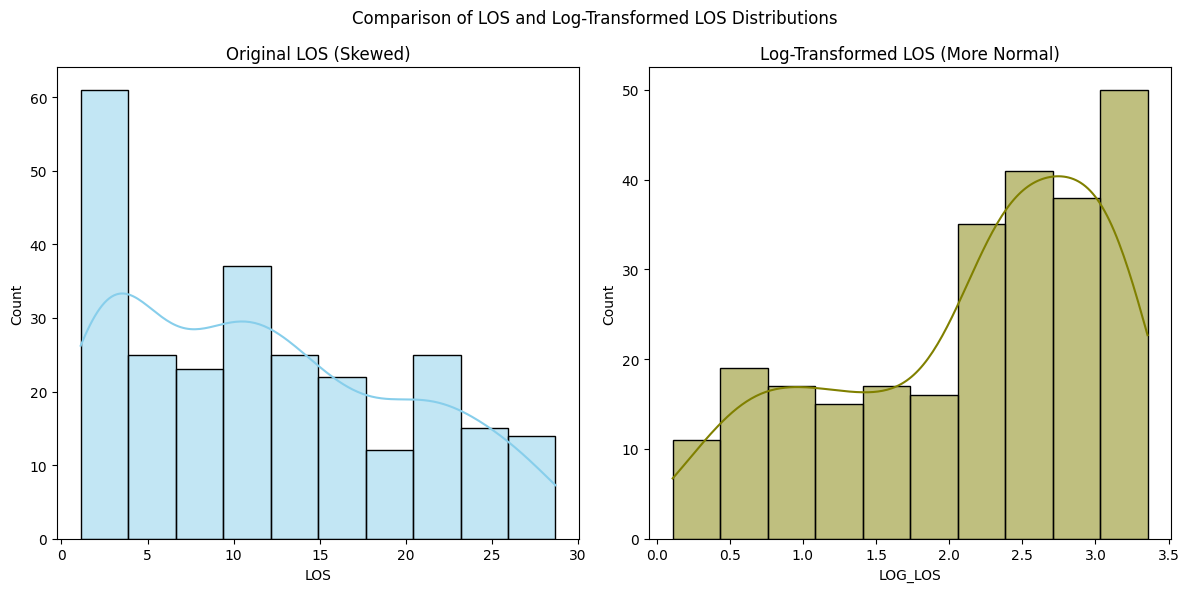

In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_icustays_patients_merged_copy = df_icustays_patients_merged.copy()

df_icustays_patients_merged_copy['LOG_LOS'] = np.log(df_icustays_patients_merged_copy['LOS'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Comparison of LOS and Log-Transformed LOS Distributions')

sns.histplot(df_icustays_patients_merged_copy['LOS'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original LOS (Skewed)')

sns.histplot(df_icustays_patients_merged_copy['LOG_LOS'], kde=True, ax=axes[1], color='olive')
axes[1].set_title('Log-Transformed LOS (More Normal)')

plt.tight_layout()
plt.show()

In [66]:
df_icustays_patients_merged.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ICUSTAY_ID,INTIME,LOS,GENDER,DOB,AGE,HOSP_TIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
0,114,178393,48283,2146-08-29 01:18:00,258626,2146-08-29 17:59:00,1.8132,1,2098-05-09,48.306639,0.0,False,False,False,True,False
2,285,165312,48283,2152-09-21 22:47:00,238023,2152-09-21 22:48:50,28.6880,1,2107-05-16,45.353183,0.0,False,True,False,False,False
3,605,115545,48283,2197-11-09 12:59:00,248569,2197-11-09 13:00:45,16.8598,0,1895-04-05,91.400000,0.0,False,False,False,False,False
5,952,163476,48283,2180-03-02 03:35:00,229883,2180-03-02 03:36:56,5.7734,1,2118-02-15,62.043806,0.0,True,False,False,False,False
6,1062,105525,48283,2105-05-02 16:39:00,231370,2105-05-02 16:40:38,25.0238,1,2029-05-17,75.958932,0.0,False,False,False,False,True


In [67]:
df_chart_events =  pd.read_csv(data_path + 'd_pneumonia.csv', low_memory=False) 

# 1. Merge df_merged with CHARTEVENTS (left join to preserve all ICU stays)
df_merged_with_chartevents = pd.merge(
    df_icustays_patients_merged,  # Key columns
    df_chart_events[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'VALUENUM','CHARTTIME']].drop_duplicates(),
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    how='inner',
    indicator=True  # Adds a column '_merge' to show match status
)

print(df_merged_with_chartevents.shape)
 
df_merged_with_chartevents.head(1)

(834562, 20)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ICUSTAY_ID,INTIME,LOS,GENDER,DOB,AGE,HOSP_TIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,ITEMID,VALUENUM,CHARTTIME,_merge
0,114,178393,48283,2146-08-29 01:18:00,258626,2146-08-29 17:59:00,1.8132,1,2098-05-09,48.306639,0.0,False,False,False,True,False,211,72.0,2146-08-30 10:00:00,both


In [68]:
print(df_merged_with_chartevents.shape)
df_merged_with_chartevents['INTIME'] = pd.to_datetime(df_merged_with_chartevents['INTIME'])
df_merged_with_chartevents['CHARTTIME'] = pd.to_datetime(df_merged_with_chartevents['CHARTTIME'])

df_merged_with_chartevents.isnull().sum()

df_merged_with_chartevents['ITEM_ADM_TIME'] = (df_merged_with_chartevents['CHARTTIME'] - df_merged_with_chartevents['INTIME']).dt.total_seconds() / 3600
df_merged_with_chartevents = df_merged_with_chartevents[(df_merged_with_chartevents['ITEM_ADM_TIME'] <= 24) &
                                                         (df_merged_with_chartevents['ITEM_ADM_TIME'] >= 0)]
df_merged_with_chartevents.describe()

print(df_merged_with_chartevents.shape)

sns.histplot(df_merged_with_chartevents['ITEM_ADM_TIME'], kde=True)


(834562, 20)
(87861, 21)


<Axes: xlabel='ITEM_ADM_TIME', ylabel='Count'>

In [69]:
df_merged_with_chartevents['ITEM_ADM_TIME'] = df_merged_with_chartevents['ITEM_ADM_TIME'] / 24.0

sns.histplot(df_merged_with_chartevents['ITEM_ADM_TIME'], kde=True)

<Axes: xlabel='ITEM_ADM_TIME', ylabel='Count'>

In [70]:
sns.histplot(df_icustays_patients_merged['AGE'], kde=True)

<Axes: xlabel='ITEM_ADM_TIME', ylabel='Count'>

In [71]:
print(df_merged_with_chartevents.shape)
# df_merged_with_chartevents.drop(columns=['_merge','INTIME','CHARTTIME'],inplace=True)

df_merged_with_chartevents.head(1)

(87861, 21)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ICUSTAY_ID,INTIME,LOS,GENDER,DOB,AGE,...,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,ITEMID,VALUENUM,CHARTTIME,_merge,ITEM_ADM_TIME
0,114,178393,48283,2146-08-29 01:18:00,258626,2146-08-29 17:59:00,1.8132,1,2098-05-09,48.306639,...,False,False,False,True,False,211,72.0,2146-08-30 10:00:00,both,0.667361


In [72]:
# df_merged_with_chartevents.describe().T

In [73]:
static_features = df_merged_with_chartevents.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])[
    ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','HOSP_TIME', 'AGE', 'GENDER', 
     'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC OR LATINO', 
     'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED', 'ETH_WHITE','LOS']
]

static_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,HOSP_TIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOS
0,114,178393,258626,0.000000,48.306639,1,False,False,False,True,False,1.8132
1950,285,165312,238023,0.000000,45.353183,1,False,True,False,False,False,28.6880
10291,605,115545,248569,0.000000,91.400000,0,False,False,False,False,False,16.8598
17828,3482,192399,202786,0.002738,55.577687,1,False,False,False,False,True,4.9694
19519,2090,138877,256557,0.000000,76.605065,1,False,False,False,False,True,10.0869


In [74]:
import pandas as pd
import numpy as np

# This function now correctly expects a list of IDs for the third argument.
# The 'features_df' (for mapping names) is now a separate, optional argument.
def create_feature_matrix(df_events, df_static, item_ids, features_df=None, agg_list=None):
    """
    Creates a feature matrix by combining static data with aggregated time-series features.
    This version correctly accepts a list of ITEMIDs and robustly flattens MultiIndex columns.

    Args:
        df_events (pd.DataFrame): Time-series data with 'SUBJECT_ID', 'ITEMID', 'VALUENUM', 'CHARTTIME'.
        df_static (pd.DataFrame): Static patient data with 'SUBJECT_ID'.
        item_ids (list): A Python list of ITEMIDs to use for feature generation.
        features_df (pd.DataFrame, optional): For mapping ITEMID to readable names. 
                                               Must have 'ITEMID' and 'item_name' columns. Defaults to None.
        agg_list (list, optional): Aggregations to compute. Defaults to ['mean', 'std', 'count', 'range', 'trend'].

    Returns:
        pd.DataFrame: Combined static + aggregated features, with NaN filled as 0.
    """
    if agg_list is None:
        agg_list = ['mean', 'std', 'count', 'range', 'trend']

    # 1. Filter relevant ITEMIDs from the provided list
    df_filtered = df_events[df_events['ITEMID'].isin(item_ids)].copy()
    df_filtered['CHARTTIME'] = pd.to_datetime(df_filtered['CHARTTIME'])

    # 2. Define aggregation calculations (no changes here)
    def calculate_aggregated_features(group):
        vals = group['VALUENUM']
        count = vals.count()
        features = {}
        for agg in agg_list:
            features[agg] = 0
        if count == 0:
            return pd.Series(features)
        if 'count' in agg_list: features['count'] = count
        if 'mean' in agg_list: features['mean'] = vals.mean()
        if 'std' in agg_list: features['std'] = vals.std() if count > 1 else 0
        if 'range' in agg_list: features['range'] = vals.max() - vals.min() if count > 1 else 0
        if 'trend' in agg_list and count > 1:
            group = group.sort_values('CHARTTIME')
            time_in_hours = (group['CHARTTIME'] - group['CHARTTIME'].iloc[0]).dt.total_seconds() / 3600.0
            valid_indices = time_in_hours.notna() & vals.notna()
            if valid_indices.sum() > 1:
                slope = np.polyfit(time_in_hours[valid_indices], vals[valid_indices], 1)[0]
                features['trend'] = slope if np.isfinite(slope) else 0
        return pd.Series(features)

    # 3. Compute aggregations
    item_stats = (
        df_filtered.groupby(['SUBJECT_ID', 'ITEMID'])
        .apply(calculate_aggregated_features)
        .unstack(fill_value=0)
    )
    
    # 4. Flatten MultiIndex columns (Robust Fix)
    if isinstance(item_stats.columns, pd.MultiIndex):
        if features_df is not None:
            # Ensure data types match for mapping
            features_df['ITEMID'] = features_df['ITEMID'].astype(int)
            itemid_to_label = dict(zip(features_df['ITEMID'], features_df['item_name']))
            item_stats.columns = [
                f"{agg}_{itemid_to_label.get(int(itemid), f'ITEM_{itemid}')}"
                for agg, itemid in item_stats.columns
            ]
        else: # If no features_df is provided, use default names
            item_stats.columns = [
                f"{agg}_ITEM_{itemid}" for agg, itemid in item_stats.columns
            ]

    item_stats = item_stats.reset_index()

    # 5. Merge with static data
    model_data = pd.merge(
        df_static,
        item_stats,
        on='SUBJECT_ID',
        how='left'
    ).fillna(0)

    return model_data

In [75]:
top_features_df = pd.read_csv(data_path + 'items_appearance_pneumonia.csv')

top_features_df.head()

,rank,ITEMID,item_name,VALUEUOM,stay_count
0,1,220645.0,Sodium (serum),mEq/L,135
1,2,220615.0,Creatinine,mg/dL,135
2,3,220602.0,Chloride (serum),mEq/L,135
3,4,225624.0,BUN,mg/dL,135
4,5,227443.0,HCO3 (serum),mEq/L,135


In [76]:
top32_features = top_features_df[top_features_df['rank'] <= 32]['ITEMID'].to_list()

print('The number of items is: ', len(top32_features))

The number of items is:  32


In [77]:
model_data_full = create_feature_matrix(
    df_merged_with_chartevents,
    static_features,
    top32_features, # The list of ITEMIDs
    features_df=top_features_df # The dataframe for naming (optional)
)
print(model_data_full.shape)
model_data_full.head(1)


(126, 172)


/tmp/ipykernel_142437/4268334774.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_aggregated_features)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,HOSP_TIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Calcium non-ionized,trend_Phosphorous,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_Potassium (serum),trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time,trend_INR
0,114,178393,258626,0.0,48.306639,1,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
# Define SOFA-related ITEMIDs (This part is perfect)
sofa_itemids = {
    'RESPIRATION': [220224, 223835],  # PaO₂, FiO₂
    'COAGULATION': [828],           # Platelets
    'LIVER': [225690],                 # Bilirubin
    'CARDIOVASCULAR': [220052],       # MAP
    'CNS': [198],                     # GCS
    'RENAL': [220615]           # Creatinine
}

# 1. Flatten the list of ITEMIDs (This part is also perfect)
all_sofa_ids = [item for sublist in sofa_itemids.values() for item in sublist]

# 2. Apply the filter directly (More efficient)
df_sofa_components = df_chart_events[df_chart_events['ITEMID'].isin(all_sofa_ids)]

print(f"Found {len(df_sofa_components)} SOFA-related measurements.")
df_sofa_components.head(1)

Found 67420 SOFA-related measurements.


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,170754,1709,127294,207018,220052,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,124.0,124.0,mmHg,0.0,0.0,NaN,NaN


In [79]:
# Extract PaO₂ and FiO₂ (assuming FiO₂ is in %, e.g., 50% = 0.5)
df_pao2 = df_sofa_components[df_sofa_components['ITEMID'] == 220224]
df_fio2 = df_sofa_components[df_sofa_components['ITEMID'] == 223835]
df_pao2

# Merge and calculate PaO₂/FiO₂ ratio
df_respiration = pd.merge(
    df_pao2[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'VALUENUM']],
    df_fio2[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'VALUENUM']],
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME'],
    suffixes=('_PAO2', '_FIO2')
)

df_respiration['PAO2_FIO2_RATIO'] = df_respiration['VALUENUM_PAO2'] / (df_respiration['VALUENUM_FIO2'] / 100)

# Assign SOFA Respiration Subscore (0-4)
df_respiration['SOFA_RESPIRATION'] = pd.cut(
    df_respiration['PAO2_FIO2_RATIO'],
    bins=[0, 100, 200, 300, 400, float('inf')],
    labels=[4, 3, 2, 1, 0],
    right=False
)

df_respiration.head(2)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,VALUENUM_PAO2,VALUENUM_FIO2,PAO2_FIO2_RATIO,SOFA_RESPIRATION
0,3482,192399,202786,2152-11-18 20:00:00,106.0,30.0,353.333333,1
1,12110,105928,212945,2172-03-02 09:00:00,154.0,50.0,308.000000,1


In [80]:
df_platelets = df_sofa_components[df_sofa_components['ITEMID'] == 828].copy()

df_platelets['SOFA_COAGULATION'] = pd.cut(
    df_platelets['VALUENUM'],
    bins=[0, 20, 50, 100, 150, float('inf')],
    labels=[4, 3, 2, 1, 0],
    right=False
)
df_platelets.head(3)
# df_platelets.describe()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,SOFA_COAGULATION
941838,35644178,285,165312,238023,828,2152-09-26 01:03:00,2152-09-26 02:08:00,15331.0,181.0,181.0,NaN,NaN,NaN,Final,NotStopd,0
942333,35661979,285,165312,238023,828,2152-10-12 01:42:00,2152-10-12 02:39:00,15331.0,260.0,260.0,NaN,NaN,NaN,Final,NotStopd,0
942532,35667689,285,165312,238023,828,2152-10-18 02:29:00,2152-10-18 03:48:00,15331.0,333.0,333.0,NaN,NaN,NaN,Final,NotStopd,0


In [81]:
df_bilirubin = df_sofa_components[df_sofa_components['ITEMID'] == 225690].copy()

df_bilirubin['SOFA_LIVER'] = pd.cut(
    df_bilirubin['VALUENUM'],
    bins=[0, 1.2, 2.0, 6.0, 12.0, float('inf')],
    labels=[0, 1, 2, 3, 4],
    right=False
)

df_bilirubin.head(100)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,SOFA_LIVER
33,170787,1709,127294,207018,225690,2118-01-04 12:45:00,2118-01-04 14:39:00,20889.0,1.9,1.9,mg/dL,1.0,0.0,NaN,NaN,1
269,171808,1709,127294,207018,225690,2118-01-06 04:50:00,2118-01-06 05:27:00,20889.0,2.5,2.5,mg/dL,1.0,0.0,NaN,NaN,2
333,171233,1709,127294,207018,225690,2118-01-05 03:08:00,2118-01-05 04:03:00,20889.0,2.3,2.3,mg/dL,1.0,0.0,NaN,NaN,2
502,170235,1709,127294,207018,225690,2118-01-03 05:23:00,2118-01-03 07:01:00,20889.0,0.9,0.9,mg/dL,0.0,0.0,NaN,NaN,0
1006,173894,1709,127294,207018,225690,2118-01-11 03:51:00,2118-01-11 04:57:00,20889.0,0.8,0.8,mg/dL,0.0,0.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51806,2024498,17190,106415,211988,225690,2107-12-20 01:57:00,2107-12-20 02:46:00,20889.0,0.9,0.9,mg/dL,0.0,0.0,NaN,NaN,0
52305,2011200,17190,106415,211988,225690,2107-11-20 04:01:00,2107-11-20 04:52:00,20889.0,0.4,0.4,mg/dL,0.0,0.0,NaN,NaN,0
52396,2021570,17190,106415,211988,225690,2107-12-11 05:34:00,2107-12-11 06:14:00,20889.0,0.7,0.7,mg/dL,0.0,0.0,NaN,NaN,0
54655,2012388,17190,106415,211988,225690,2107-11-22 01:47:00,2107-11-22 20:02:00,20889.0,0.6,0.6,mg/dL,0.0,0.0,NaN,NaN,0


In [82]:
df_vasopressors = df_sofa_components[df_sofa_components['ITEMID'] == 220052].copy()

# Check vasopressor use (you may need to extract these separately)
# Example: Noradrenaline (ITEMID: 221906), Dopamine (ITEMID: 221662)
# Assign SOFA Cardiovascular Subscore
df_vasopressors['SOFA_CARDIOVASCULAR'] = pd.cut(
    df_vasopressors['VALUENUM'],
    bins=[0, 70, float('inf')],
    labels=[1, 0],  # 1 if MAP < 70, else 0
    right=False
)

# If vasopressors are used, increase score to 3 or 4
# (This requires additional logic)
df_vasopressors['SOFA_CARDIOVASCULAR'].value_counts()

SOFA_CARDIOVASCULAR
0    25909
1     7634
Name: count, dtype: int64

In [83]:
df_gcs = df_sofa_components[df_sofa_components['ITEMID'] == 198].copy()

df_gcs['SOFA_CNS'] = pd.cut(
    df_gcs['VALUENUM'],
    bins=[0, 6, 9, 12, 14, 16],
    labels=[4, 3, 2, 1, 0],
    right=False
)
df_gcs.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,SOFA_CNS
940886,35647251,285,165312,238023,198,2152-09-28 03:00:00,2152-09-28 05:36:00,14997.0,9.0,9.0,points,NaN,NaN,NaN,NotStopd,2
940923,35654790,285,165312,238023,198,2152-10-04 07:00:00,2152-10-04 06:45:00,17048.0,11.0,11.0,points,NaN,NaN,NaN,NotStopd,2


In [84]:
df_creatinine = df_sofa_components[df_sofa_components['ITEMID'] == 220615].copy()

df_creatinine['SOFA_RENAL'] = pd.cut(
    df_creatinine['VALUENUM'],
    bins=[0, 1.2, 2.0, 3.5, 5.0, float('inf')],
    labels=[0, 1, 2, 3, 4],
    right=False
)

df_creatinine.head()


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,SOFA_RENAL
23,170777,1709,127294,207018,220615,2118-01-04 12:45:00,2118-01-04 14:39:00,20889.0,7.1,7.1,mg/dL,1.0,0.0,NaN,NaN,4
114,170225,1709,127294,207018,220615,2118-01-03 05:23:00,2118-01-03 07:01:00,20889.0,6.6,6.6,mg/dL,1.0,0.0,NaN,NaN,4
259,171798,1709,127294,207018,220615,2118-01-06 04:50:00,2118-01-06 05:27:00,20889.0,4.8,4.8,mg/dL,1.0,0.0,NaN,NaN,3
323,171223,1709,127294,207018,220615,2118-01-05 03:08:00,2118-01-05 04:03:00,20889.0,6.0,6.0,mg/dL,1.0,0.0,NaN,NaN,4
553,173781,1709,127294,207018,220615,2118-01-10 22:59:00,2118-01-10 23:55:00,20889.0,6.7,6.7,mg/dL,1.0,0.0,NaN,NaN,4


In [85]:
# Merge all subscores (example)
df_sofa_scores = pd.concat([
    df_respiration[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_RESPIRATION']],
    df_platelets[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_COAGULATION']],
    df_bilirubin[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_LIVER']],
    df_vasopressors[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_CARDIOVASCULAR']],
    df_gcs[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_CNS']],
    df_creatinine[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'SOFA_RENAL']]
])
df_sofa_scores = df_sofa_scores.fillna(0)
df_sofa_scores.head(2)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,SOFA_RESPIRATION,SOFA_COAGULATION,SOFA_LIVER,SOFA_CARDIOVASCULAR,SOFA_CNS,SOFA_RENAL
0,3482,192399,202786,1,0,0,0,0,0
1,12110,105928,212945,1,0,0,0,0,0


In [86]:
# 1. First ensure each component has only one score per ICU stay by taking the worst (max) score
sofa_components = ['SOFA_RESPIRATION', 'SOFA_COAGULATION', 'SOFA_LIVER', 
                   'SOFA_CARDIOVASCULAR', 'SOFA_CNS', 'SOFA_RENAL']

df_sofa_scores_aggregated = df_sofa_scores.groupby(
    ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']
)[sofa_components].max().reset_index()

# 2. Verify uniqueness
print(f"Before aggregation: {len(df_sofa_scores)} records")
print(f"After aggregation: {len(df_sofa_scores_aggregated)} unique ICU stays")
print("Duplicate check:", df_sofa_scores_aggregated.duplicated(subset=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']).any())

# 3. Now merge with your main data
df_model_full_with_sofa = pd.merge(
    left=model_data_full,
    right=df_sofa_scores_aggregated,
    how='left',
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    validate='one_to_one'  # This will now pass
)

# 4. Calculate total SOFA (handle missing components as 0)
df_model_full_with_sofa['total_sofa'] = df_model_full_with_sofa[sofa_components].fillna(0).sum(axis=1)

Before aggregation: 37829 records
After aggregation: 146 unique ICU stays
Duplicate check: False


In [87]:
df_model_full_with_sofa.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,HOSP_TIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Platelet Count,trend_Prothrombin time,trend_INR,SOFA_RESPIRATION,SOFA_COAGULATION,SOFA_LIVER,SOFA_CARDIOVASCULAR,SOFA_CNS,SOFA_RENAL,total_sofa
0,114,178393,258626,0.000000,48.306639,1,False,False,False,True,...,0.000000,0.000000,0.000000,0,0,0,0,0,0,0
1,285,165312,238023,0.000000,45.353183,1,False,True,False,False,...,0.000000,0.000000,0.000000,0,0,0,0,0,0,0
2,605,115545,248569,0.000000,91.400000,0,False,False,False,False,...,0.082418,0.000000,0.000000,0,0,1,0,0,2,3
3,3482,192399,202786,0.002738,55.577687,1,False,False,False,False,...,0.000000,0.000000,0.000000,0,0,0,0,0,0,0
4,2090,138877,256557,0.000000,76.605065,1,False,False,False,False,...,-1.545801,0.055427,0.013857,0,0,2,0,0,2,4


In [88]:
df_model_full_with_sofa = df_model_full_with_sofa.drop(columns=sofa_components)
df_model_full_with_sofa.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,HOSP_TIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Phosphorous,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_Potassium (serum),trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time,trend_INR,total_sofa
0,114,178393,258626,0.000000,48.306639,1,False,False,False,True,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,285,165312,238023,0.000000,45.353183,1,False,True,False,False,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,605,115545,248569,0.000000,91.400000,0,False,False,False,False,...,0.089292,-0.073447,-7.002831e-16,0.137920,-0.124548,0.433000,0.082418,0.000000,0.000000,3
3,3482,192399,202786,0.002738,55.577687,1,False,False,False,False,...,0.000000,0.243856,-5.129622e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,2090,138877,256557,0.000000,76.605065,1,False,False,False,False,...,-0.021077,-0.016348,1.739162e-15,0.075682,-0.031053,-0.258931,-1.545801,0.055427,0.013857,4


In [89]:
from sklearn.feature_selection import VarianceThreshold
# only works on numerical features
selector = VarianceThreshold(threshold=0.01)  # drop features with <1% variance

model_data_full = df_model_full_with_sofa.copy()

non_numerical_feature_cols = ['SUBJECT_ID','HADM_ID','ICUSTAY_ID','LOS']

feature_cols = [col for col in model_data_full.columns if col not in non_numerical_feature_cols]

features_df = model_data_full[feature_cols]
selector.fit(features_df)

kept_cols = features_df.columns[selector.get_support()]

print(f"Original number of features: {len(feature_cols)}")
print(f"Number of features kept: {len(kept_cols)}")

final_cols_to_keep = non_numerical_feature_cols + kept_cols.tolist()
df_selected = model_data_full[final_cols_to_keep]
# df_selected = model_data_full
print("\nShape of the new DataFrame:", df_selected.shape)
print("\nFirst 5 rows of the new DataFrame with selected features:")
df_selected.head(1)

Original number of features: 169
Number of features kept: 154

Shape of the new DataFrame: (126, 158)

First 5 rows of the new DataFrame with selected features:


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOS,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Resp Alarm - High,trend_Arterial Base Excess,trend_BUN,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time,total_sofa
0,114,178393,258626,1.8132,48.306639,1,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [90]:
dropped_cols_mask = ~selector.get_support()
dropped_cols = features_df.columns[dropped_cols_mask]
# Dropped columns
dropped_cols

Index(['HOSP_TIME', 'std_PH (Arterial)', 'range_PH (Arterial)',
       'trend_Hemoglobin', 'trend_O2 saturation pulseoxymetry',
       'trend_Creatinine', 'trend_Magnesium',
       'trend_O2 Saturation Pulseoxymetry Alarm - High',
       'trend_O2 Saturation Pulseoxymetry Alarm - Low', 'trend_PH (Arterial)',
       'trend_Resp Alarm - Low', 'trend_Calcium non-ionized',
       'trend_Phosphorous', 'trend_Potassium (serum)', 'trend_INR'],
      dtype='object')

Generating heatmap for features before correlation-based removal...


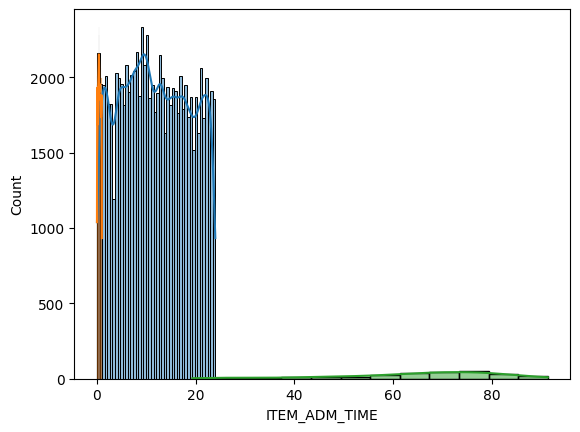

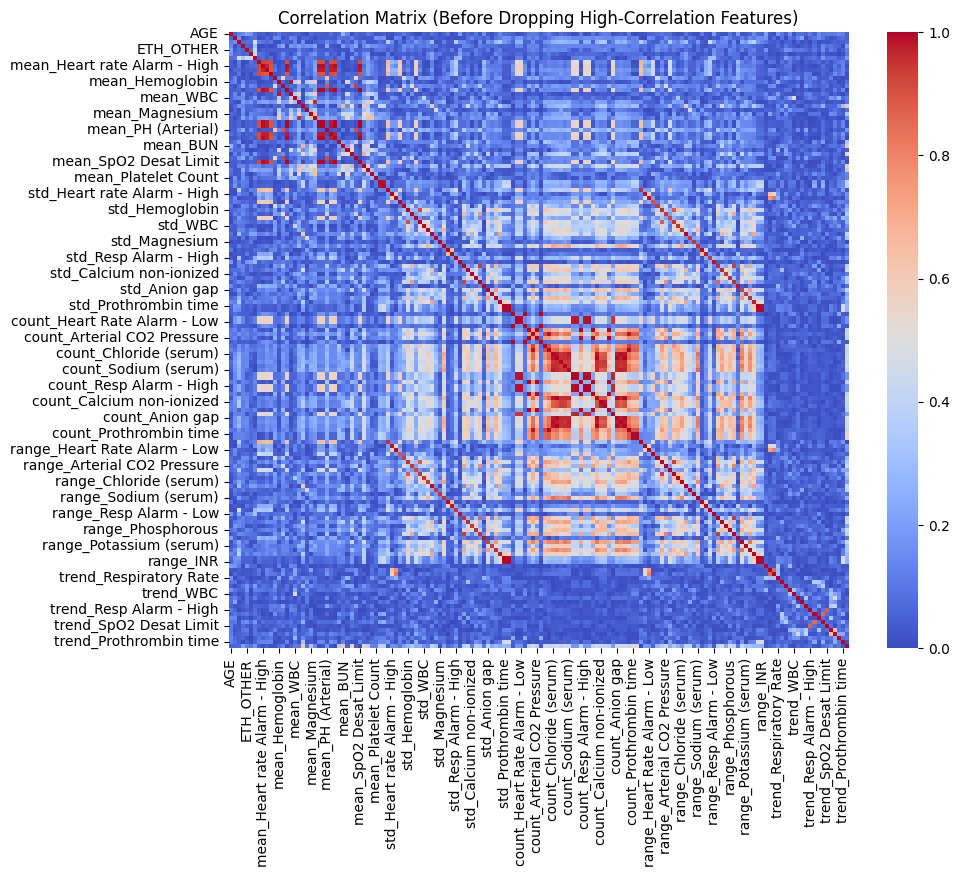

In [91]:
X = df_selected.drop(columns=non_numerical_feature_cols)

corr_matrix = X.corr().abs()

print("Generating heatmap for features before correlation-based removal...")

plt.figure(figsize=(10, 8))  # Adjust size as needed for readability
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False) # annot=True can be used for smaller matrices
plt.title('Correlation Matrix (Before Dropping High-Correlation Features)')
plt.show()


In [92]:
df_selected.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS', 'AGE', 'GENDER',
       'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC OR LATINO', 'ETH_OTHER',
       'ETH_UNKNOWN/NOT SPECIFIED',
       ...
       'trend_Resp Alarm - High', 'trend_Arterial Base Excess', 'trend_BUN',
       'trend_TCO2 (calc) Arterial', 'trend_SpO2 Desat Limit',
       'trend_Anion gap', 'trend_HCO3 (serum)', 'trend_Platelet Count',
       'trend_Prothrombin time', 'total_sofa'],
      dtype='object', length=158)

Number of high-correlation feature pairs (corr > 0.9): 171
Number of correlated feature clusters: 38
Cluster 1: size = 10 → dropping 9
Cluster 2: size = 2 → dropping 1
Cluster 3: size = 3 → dropping 2
Cluster 4: size = 2 → dropping 1
Cluster 5: size = 2 → dropping 1
Cluster 6: size = 2 → dropping 1
Cluster 7: size = 2 → dropping 1
Cluster 8: size = 2 → dropping 1
Cluster 9: size = 2 → dropping 1
Cluster 10: size = 4 → dropping 3
Cluster 11: size = 2 → dropping 1
Cluster 12: size = 2 → dropping 1
Cluster 13: size = 2 → dropping 1
Cluster 14: size = 2 → dropping 1
Cluster 15: size = 2 → dropping 1
Cluster 16: size = 2 → dropping 1
Cluster 17: size = 2 → dropping 1
Cluster 18: size = 2 → dropping 1
Cluster 19: size = 2 → dropping 1
Cluster 20: size = 2 → dropping 1
Cluster 21: size = 2 → dropping 1
Cluster 22: size = 2 → dropping 1
Cluster 23: size = 4 → dropping 3
Cluster 24: size = 2 → dropping 1
Cluster 25: size = 2 → dropping 1
Cluster 26: size = 2 → dropping 1
Cluster 27: size = 2 → 

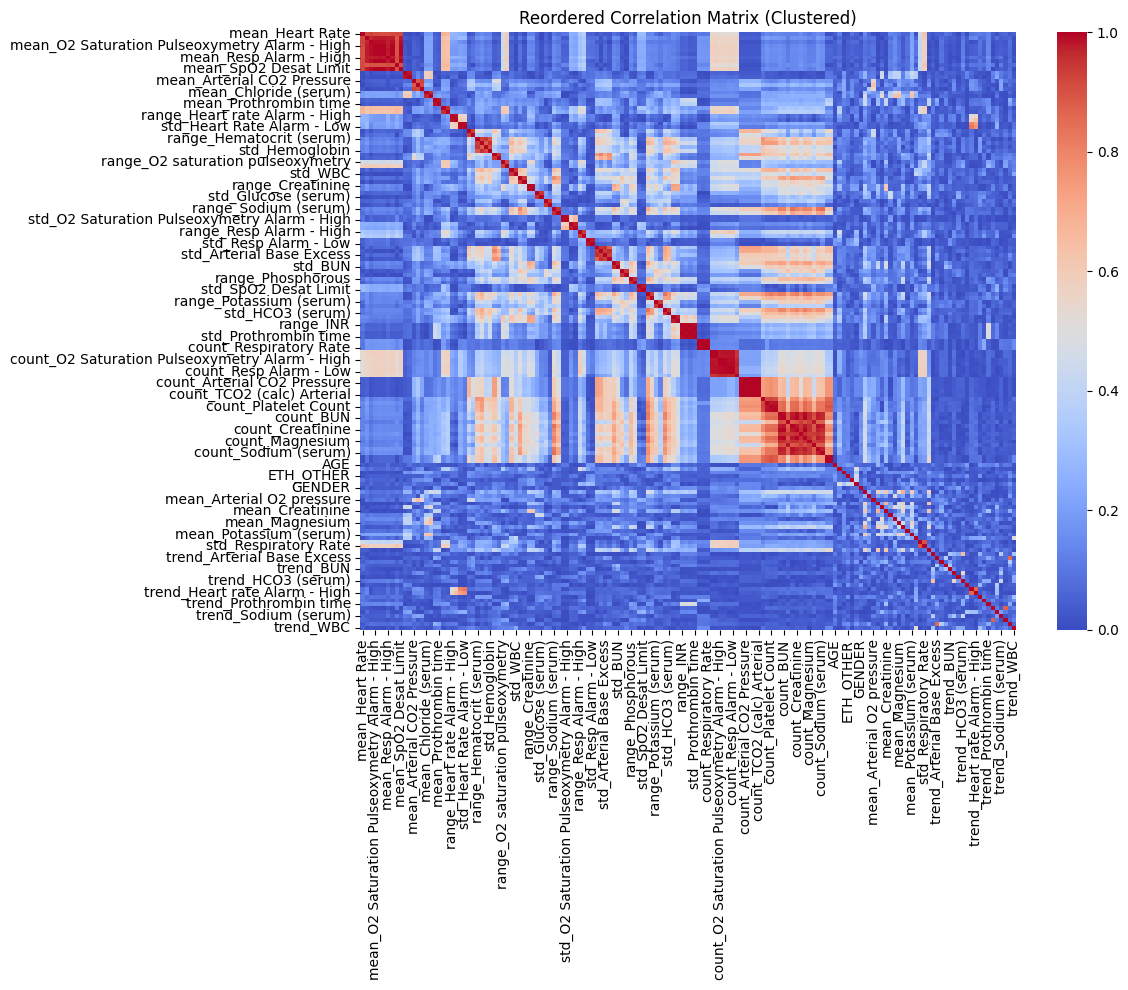

In [93]:
import networkx as nx

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3: Extract highly correlated feature pairs (threshold > 0.9)
high_corr_pairs = upper.stack()[upper.stack() > 0.9]

print(f"Number of high-correlation feature pairs (corr > 0.9): {len(high_corr_pairs)}")

df_reduced = df_selected.drop(columns=['HADM_ID', 'ICUSTAY_ID', 'LOS', 'SUBJECT_ID'])

# Step 4: Build graph and find connected components (clusters)
G = nx.Graph()
G.add_edges_from(high_corr_pairs.index.tolist())

clusters = list(nx.connected_components(G))

print(f"Number of correlated feature clusters: {len(clusters)}")

# Step 5: Debug cluster sizes
for i, group in enumerate(clusters):
    print(f"Cluster {i+1}: size = {len(group)} → dropping {len(group) - 1}")

# Step 6: Compute features to drop (keep first in each group)
to_drop_groups = [list(group)[1:] for group in clusters if len(group) > 1]
to_drop = [item for sublist in to_drop_groups for item in sublist]

print(f"Total number of features to drop: {len(to_drop)}")
print("Features being dropped:", to_drop)

# Step 7: Drop the features
df_reduced = df_reduced.drop(columns=to_drop)

# Step 8: Reorder features for visual inspection
ordered_features = [feat for group in clusters for feat in sorted(group)]
remaining_features = [f for f in df_reduced.columns if f not in ordered_features]
ordered_features += sorted(remaining_features)

reordered_corr = corr_matrix.loc[ordered_features, ordered_features]

# Step 9: Plot the reordered correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(reordered_corr, cmap='coolwarm', annot=False)
plt.title("Reordered Correlation Matrix (Clustered)")
plt.tight_layout()
plt.show()

In [94]:
df_final_selected_elimcorr = df_selected.drop(columns=to_drop)
df_final_selected_noelimcorr = df_selected

print(f"\nFinal number of features: {df_final_selected_elimcorr.shape[1] - len(non_numerical_feature_cols)}")
print("Shape of the final DataFrame:", df_final_selected_elimcorr.shape)
print("\nFirst 5 rows of the final DataFrame:")
df_final_selected_elimcorr.head(1)


Final number of features: 81
Shape of the final DataFrame: (126, 85)

First 5 rows of the final DataFrame:


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOS,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Resp Alarm - High,trend_Arterial Base Excess,trend_BUN,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time,total_sofa
0,114,178393,258626,1.8132,48.306639,1,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


- Isolate Features (X): We start with df_variance_selected, the DataFrame that has already been filtered for low variance. We create X which contains only the feature columns from this set.
- Correlation Matrix: We compute the correlation matrix for X and take the absolute value, as we're interested in the strength of the correlation, not its direction (positive or negative).
- Upper Triangle: The line np.triu(...) creates a mask for the upper triangle of the matrix (everything above the main diagonal). We do this because a correlation matrix is symmetrical (corr(A,B) is the same as corr(B,A)), and we only need to check each pair of features once to avoid redundancy.
- Find Columns to Drop: We iterate through the columns of our upper-triangle view. If any value in a column is greater than our threshold (0.9), we add that column's name to our to_drop list. This effectively keeps one feature from each highly correlated pair and flags the other for removal.
- Create Final DataFrame: We drop the columns in the to_drop list from df_variance_selected to produce our final, cleaned dataset df_final_selected.


Generating heatmap for the final set of features...


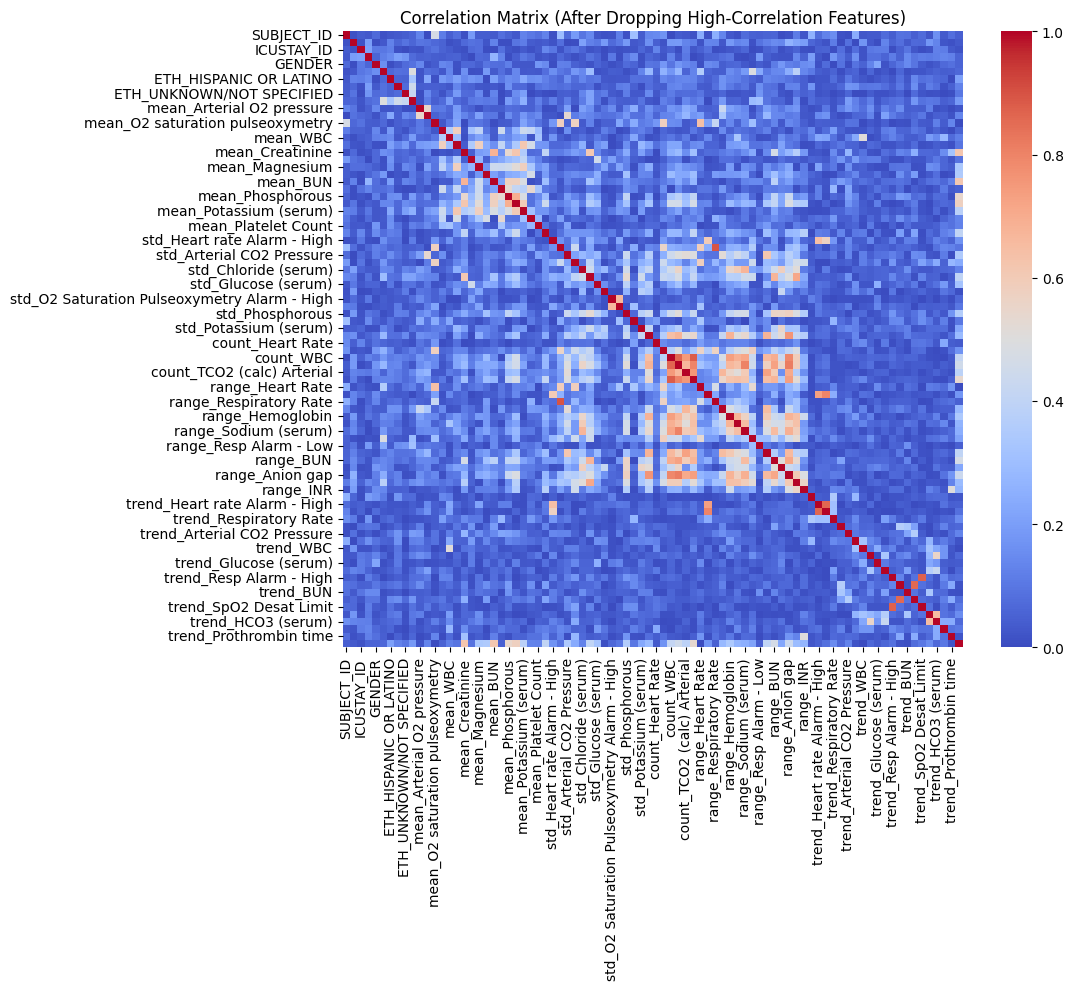

In [95]:

# print(non_numerical_feature_cols)
# final_features = df_final_selected_copy.drop(columns=non_numerical_feature_cols)
final_features = df_final_selected_elimcorr.drop(columns='LOS')

# Calculate the new correlation matrix
final_corr_matrix = final_features.corr().abs()

print("\nGenerating heatmap for the final set of features...")

plt.figure(figsize=(10, 8)) # Can be a bit smaller as there are fewer features
sns.heatmap(final_corr_matrix, cmap='coolwarm', annot=False, vmin=0, vmax=1)
plt.title('Correlation Matrix (After Dropping High-Correlation Features)')
plt.show()


In [96]:
df_final_selected_elimcorr.shape

(126, 85)

In [97]:
df_final_selected_elimcorr.head(1)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOS,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Resp Alarm - High,trend_Arterial Base Excess,trend_BUN,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time,total_sofa
0,114,178393,258626,1.8132,48.306639,1,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

def filter_low_importance_features(df, target_column, group_column=None, threshold=0.01, n_splits=5, n_repeats=5):
    """
    Filter features based on permutation importance across multiple GroupKFold splits.
    
    Parameters:
    - df: DataFrame containing features and target
    - target_column: Name of the target column
    - group_column: Name of the column used for grouping (optional)
    - threshold: Minimum relative importance to keep a feature (default: 0.01)
    - n_splits: Number of splits for GroupKFold (default: 5)
    - n_repeats: Number of repeats for permutation importance (default: 5)
    
    Returns:
    - DataFrame with selected features and target column
    """
    # Prepare data
    y = df[target_column]
    X = df.drop(columns=[target_column, 'HADM_ID', 'SUBJECT_ID', 'ICUSTAY_ID', 'LOS'])
    groups = df[group_column] if group_column else np.arange(len(df))
    
    # Initialize model and cross-validator
    model = XGBRegressor(n_estimators=1000, early_stopping_rounds=10, eval_metric='rmse', verbosity=0)
    gkf = GroupKFold(n_splits=n_splits)
    
    # Store importances from all folds
    fold_importances = []
    
    for train_idx, val_idx in gkf.split(X, y, groups):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Fit model with early stopping
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        # Calculate permutation importance
        result = permutation_importance(
            model, X_val, y_val, 
            n_repeats=n_repeats, 
            scoring='neg_root_mean_squared_error', 
            random_state=42
        )
        fold_importances.append(result.importances_mean)
    
    # Average importances across all folds
    avg_importances = np.mean(fold_importances, axis=0)
    relative_importances = avg_importances / np.sum(avg_importances)
    
    # Select features meeting importance threshold
    important_features = X.columns[relative_importances >= threshold]
    print(f"Retaining {len(important_features)} features out of {X.shape[1]} with importance ≥{threshold:.1%}")
    
    # Return selected features plus target column
    return df[important_features.tolist() + [target_column]]

# Example usage:
df_final_selected = filter_low_importance_features(
    df_final_selected_elimcorr, 
    target_column='LOS', 
    group_column='SUBJECT_ID',
    threshold=0.01
)

Retaining 18 features out of 81 with importance ≥1.0%


In [99]:
df_final_selected.head()

,ETH_UNKNOWN/NOT SPECIFIED,mean_Arterial O2 pressure,mean_Arterial CO2 Pressure,mean_Magnesium,mean_Arterial Base Excess,mean_BUN,mean_Anion gap,mean_HCO3 (serum),mean_Platelet Count,std_Creatinine,std_Glucose (serum),std_Potassium (serum),count_Heart Rate Alarm - Low,range_Resp Alarm - High,range_Arterial Base Excess,range_Platelet Count,trend_Respiratory Rate,total_sofa,LOS
0,True,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0,1.8132
1,False,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0,28.6880
2,False,183.000000,38.000000,2.333333,-4.5,54.333333,10.00,22.25,179.50,0.450925,17.521415,1.466970,3.0,0.0,7.0,1.0,0.084494,3,16.8598
3,False,95.600000,73.600000,2.700000,0.2,29.000000,13.00,26.00,187.00,0.000000,0.000000,0.000000,3.0,10.0,7.0,0.0,0.031032,0,4.9694
4,False,99.833333,27.833333,2.250000,-0.5,56.500000,16.25,21.25,218.25,0.294392,24.832774,0.432049,3.0,10.0,1.0,39.0,-0.054091,4,10.0869


Running enhanced GridSearchCV...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
GridSearchCV complete.
Cross-validated RMSE: 7.6037 ± 1.8203

--- Final Model Performance ---
MAE: 5.8024
MedianAE: 5.1013
RMSE: 7.2656
R2: 0.1292


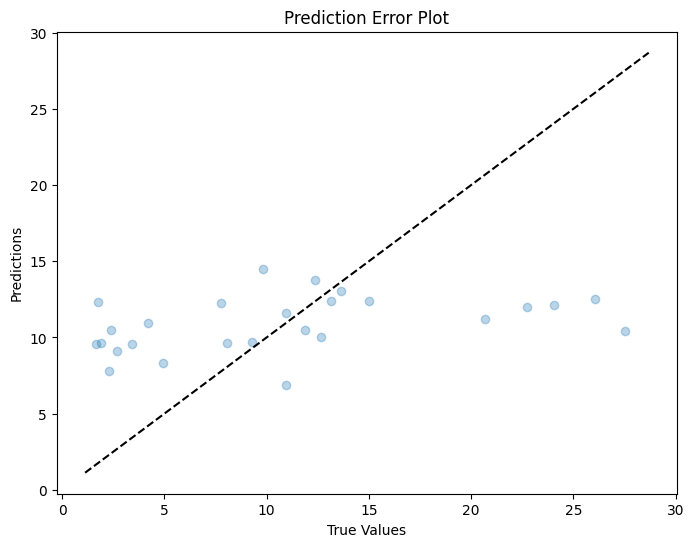

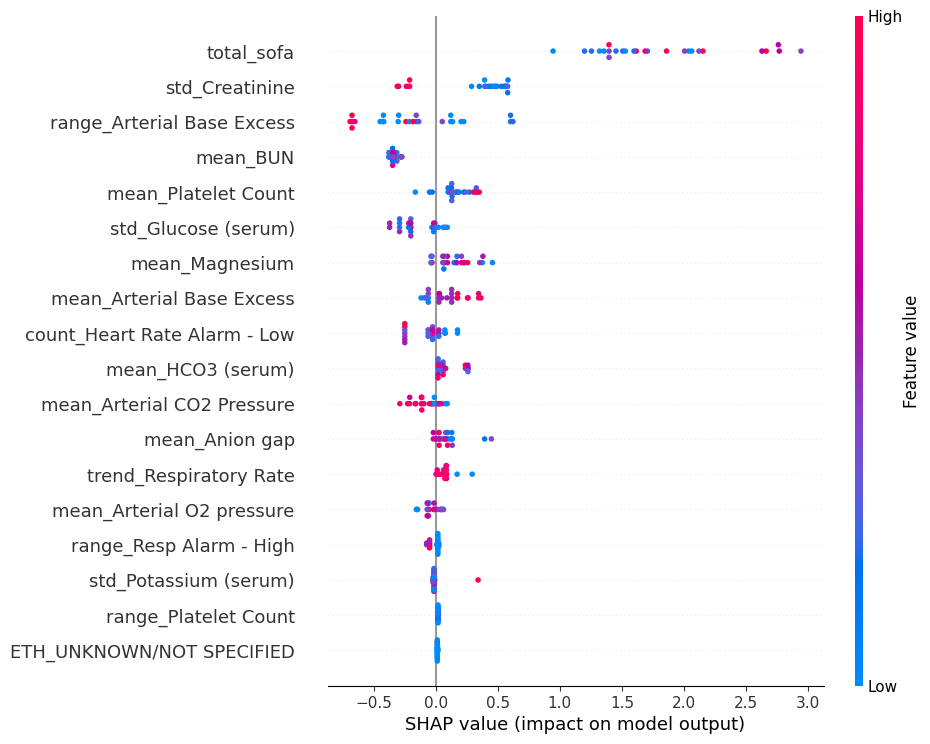

In [100]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
df_perm_selected = df_final_selected.copy()
# 1. Enhanced Data Preparation
def prepare_data(df):
    X = df.drop(columns=['LOS', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'], errors='ignore')
    y = df['LOS']
    
    # Add interaction terms for top features (example)
    if 'AGE' in X.columns and 'GENDER' in X.columns:
        X['AGE_GENDER_INTERACTION'] = X['AGE'] * X['GENDER']
    
    return X, y

X, y = prepare_data(df_perm_selected)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.qcut(y, q=5)
)

# 2. Enhanced Model Training with Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, early_stopping_rounds=30))
])

params = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__reg_alpha': [0, 0.1, 1],
    'xgb__reg_lambda': [0, 0.1, 1]
}

scaler = StandardScaler()
X_test_scaled = scaler.fit(X_train).transform(X_test)

cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)

print("Running enhanced GridSearchCV...")
model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv_splitter,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
model.fit(X_train, y_train, xgb__eval_set=[(X_test_scaled, y_test)], xgb__verbose=False)
print("GridSearchCV complete.")

from sklearn.base import clone

# 3. Comprehensive Evaluation
def evaluate_model(model, X, y):
    estimator_for_cv = clone(model.best_estimator_)

    # Disable the early stopping parameter for this specific cross-validation run
    # The pipeline step is 'xgb', so we use 'xgb__early_stopping_rounds'
    estimator_for_cv.set_params(xgb__early_stopping_rounds=None)


    cv_scores = cross_val_score(estimator_for_cv, X, y, 
                              cv=cv_splitter, scoring='neg_root_mean_squared_error')
    print(f"Cross-validated RMSE: {-cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    predictions = model.predict(X_test)
    
    metrics = {
        'MAE': mean_absolute_error(y_test, predictions),
        'MedianAE': median_absolute_error(y_test, predictions),
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'R2': r2_score(y_test, predictions)
    }
    
    print("\n--- Final Model Performance ---")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    
    # Prediction error plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, predictions, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Prediction Error Plot')
    plt.show()
    
    return metrics

metrics = evaluate_model(model, X_train, y_train)

# 4. Enhanced SHAP Analysis
def shap_analysis(model, X, sample_size=500):
    # Use best estimator from GridSearchCV
    best_model = model.best_estimator_.named_steps['xgb']
    
    # Sample data for faster computation
    if len(X) > sample_size:
        X_sample = X.sample(sample_size, random_state=42)
    else:
        X_sample = X
    
    # Compute SHAP values
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_sample)
    
    # Global feature importance
    # plt.figure(figsize=(10, 6))
    # shap.plots.bar(shap_values, max_display=20)
    # plt.title('Global Feature Importance')
    # plt.show()
    
    # Beeswarm plot
    shap.plots.beeswarm(shap_values, max_display=20)
    
    # Dependence plots for top 3 features
    # top_features = np.abs(shap_values.values).mean(0).argsort()[-3:][::-1]
    # for i in top_features:
    #     shap.plots.scatter(shap_values[:, i], color=shap_values)
    
    return shap_values

shap_values = shap_analysis(model, X_test)


=== Analyzing Prediction for Instance #62 ===
True LOS: 9.30 days
Predicted LOS: 9.72 days
Difference: 0.43 days



<Figure size 1200x400 with 0 Axes>

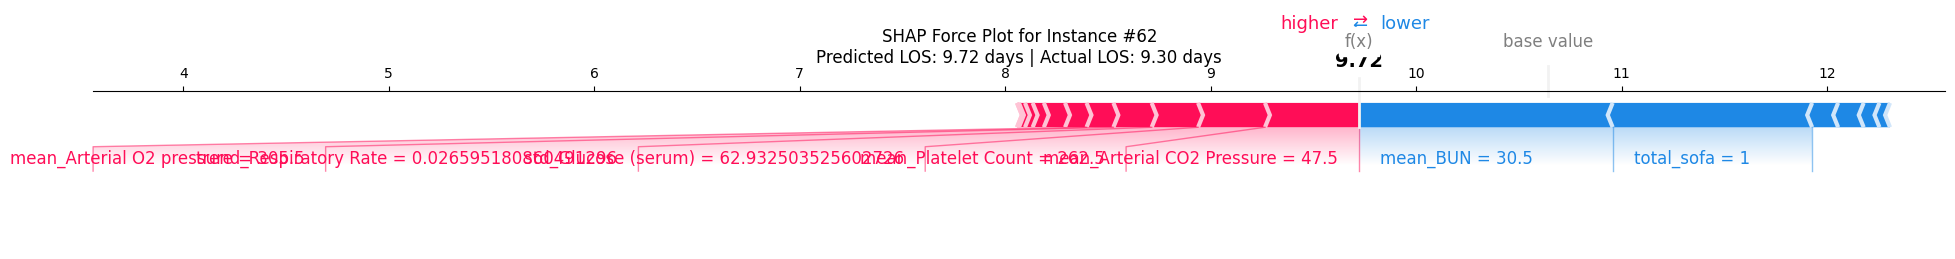

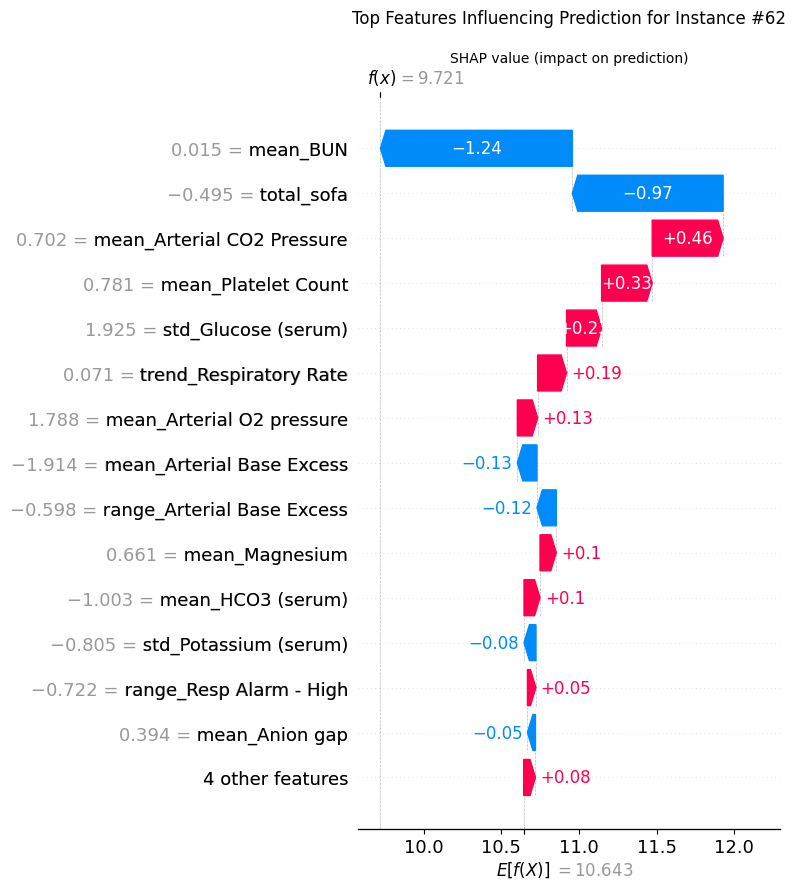


=== Detailed Feature Impacts ===
Feature                                  | Value           | SHAP Effect    
---------------------------------------------------------------------------
mean_BUN                                 | 30.500          | -1.236         
total_sofa                               | 1.000           | -0.971         
mean_Arterial CO2 Pressure               | 47.500          | 0.457          
mean_Platelet Count                      | 262.500         | 0.326          
std_Glucose (serum)                      | 62.933          | 0.226          
trend_Respiratory Rate                   | 0.027           | 0.186          
mean_Arterial O2 pressure                | 305.500         | 0.131          
mean_Arterial Base Excess                | -7.500          | -0.127         
range_Arterial Base Excess               | 1.000           | -0.124         
mean_Magnesium                           | 2.250           | 0.105          
mean_HCO3 (serum)                        | 

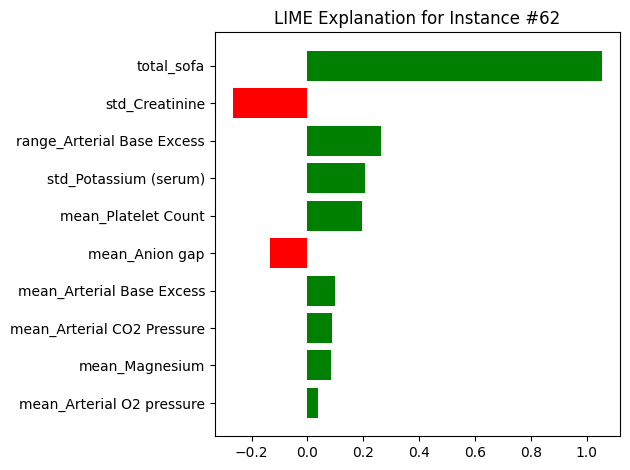


=== Top Features Affecting Prediction ===
SHAP values (higher absolute value = more impact):
mean_BUN: -1.236
total_sofa: -0.971
mean_Arterial CO2 Pressure: 0.457
mean_Platelet Count: 0.326
std_Glucose (serum): 0.226
trend_Respiratory Rate: 0.186
mean_Arterial O2 pressure: 0.131
mean_Arterial Base Excess: -0.127
range_Arterial Base Excess: -0.124
mean_Magnesium: 0.105
mean_HCO3 (serum): 0.103
std_Potassium (serum): -0.077
range_Resp Alarm - High: 0.054
mean_Anion gap: -0.052
ETH_UNKNOWN/NOT SPECIFIED: 0.037
range_Platelet Count: 0.029
count_Heart Rate Alarm - Low: 0.009
std_Creatinine: 0.000

LIME feature weights:


In [102]:
# Create a new cell after your existing code

# ======================
# Individual Prediction Interpretation
# ======================

import lime
import lime.lime_tabular
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare the explainer with feature names
best_model = model.best_estimator_.named_steps['xgb']
explainer_shap = shap.Explainer(best_model, feature_names=X.columns.tolist())

feature_names = X.columns.tolist()

np.random.seed(42)
sample_idx = np.random.choice(X_test.index)
instance = X_test.loc[[sample_idx]]
true_value = y_test.loc[sample_idx]

# Scale the instance using the same scaler
instance_scaled = scaler.transform(instance)

# Make prediction
prediction = best_model.predict(instance_scaled)[0]

print(f"\n=== Analyzing Prediction for Instance #{sample_idx} ===")
print(f"True LOS: {true_value:.2f} days")
print(f"Predicted LOS: {prediction:.2f} days")
print(f"Difference: {abs(prediction-true_value):.2f} days\n")


# 2. Generate SHAP values for our instance
shap_values = explainer_shap(instance_scaled)

# 3. Custom force plot with better formatting
plt.figure(figsize=(12, 4))
force_plot = shap.plots.force(
    explainer_shap.expected_value, 
    shap_values.values[0], 
    instance.values[0],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.title(f"SHAP Force Plot for Instance #{sample_idx}\nPredicted LOS: {prediction:.2f} days | Actual LOS: {true_value:.2f} days", 
          pad=20)
plt.tight_layout()
plt.show()

# 4. Enhanced waterfall plot
plt.figure(figsize=(10, 6))
shap.plots.waterfall(
    shap_values[0],
    max_display=15,
    show=False
)
plt.title(f"Top Features Influencing Prediction for Instance #{sample_idx}", pad=20)
plt.xlabel("SHAP value (impact on prediction)")
plt.tight_layout()
plt.show()

# 5. Print detailed feature impacts
print("\n=== Detailed Feature Impacts ===")
print(f"{'Feature':<40} | {'Value':<15} | {'SHAP Effect':<15}")
print("-" * 75)
for i in np.argsort(-np.abs(shap_values.values[0])):
    print(f"{feature_names[i]:<40} | {instance.values[0][i]:<15.3f} | {shap_values.values[0][i]:<15.3f}")

# 4. LIME Explanation
print("\nLIME Explanation:")

# Create LIME explainer (using pre-scaled data)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=scaler.transform(X_train),
    feature_names=feature_names,
    mode='regression',
    discretize_continuous=False
)

# Explain the instance
exp = explainer_lime.explain_instance(
    instance_scaled[0], 
    best_model.predict, 
    num_features=10
)

# Plot LIME explanation
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance #{sample_idx}")
plt.tight_layout()
plt.show()

# Show both explanations in text
print("\n=== Top Features Affecting Prediction ===")
print("SHAP values (higher absolute value = more impact):")
for i in np.argsort(-np.abs(shap_values.values[0])):
    print(f"{feature_names[i]}: {shap_values.values[0][i]:.3f}")

print("\nLIME feature weights:")
exp.show_in_notebook()